<a href="https://colab.research.google.com/github/studentAybu/ML_GlobalCountryMetrics2025/blob/main/ML_GlobalCountryMetrics2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Development Index Prediction Analysis based on 2025 metrics
This project aims to demonstrate the use of various libraries and concepts i.e. preprocessing data and training models.


In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas as pd
od.download(
    "https://www.kaggle.com/datasets/prashantdhanuk/global-country-metrics-2025-hdi-gdp-pop-area?resource=download")


# reading the file
file =('/content/global-country-metrics-2025-hdi-gdp-pop-area/countries_metric - Sheet1.csv')
newData = pd.read_csv(file)
newData = newData.dropna()
newData = newData.convert_dtypes()

# displaying the contents of the file
newData.head()

In [ ]:
import re
def toNumericSeries(el):
  s=str(el)
  numeric_part = ''.join(re.findall(r"\d+", s))
  return float(numeric_part)

newData['numeric_area'] = newData['AREA (in Sq km)'].apply(toNumericSeries)
newData['numeric_population']=newData['Population (in millions)'].apply(toNumericSeries)
newData['numeric_gdp_per_capita'] = newData['GDP Per capita PPP (in USD)'].apply(toNumericSeries)
newData['numeric_nominal_gdp']=newData['Nominal GDP Per capita (in USD)'].apply(toNumericSeries)
newData['numeric_nominal_gross']=newData['Nominal Gross Domestic Product (in USD)'].apply(toNumericSeries)



<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, 0 to 193
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   country_name                             174 non-null    string 
 1   Population (in millions)                 174 non-null    string 
 2   Nominal Gross Domestic Product (in USD)  174 non-null    string 
 3   Nominal GDP Per capita (in USD)          174 non-null    string 
 4   GDP Per capita PPP (in USD)              174 non-null    string 
 5   Human Development Index (HDI)            174 non-null    Float64
 6   GINI                                     174 non-null    Float64
 7   AREA (in Sq km)                          174 non-null    string 
 8   numeric_area                             174 non-null    float64
 9   numeric_population                       174 non-null    float64
 10  numeric_gdp_per_capita                   174 non-null  

In [ ]:
# Function to create HDI category
def categorize_hdi(hdi):
    if pd.isna(hdi):
        return pd.NA
    elif hdi <= 0.549:
        return 'Low'
    elif hdi <= 0.699:
        return 'Medium'
    elif hdi <= 0.799:
        return 'High'
    else:
        return 'Very High'

# Add HDI category column
newData['HDI_category'] = newData['Human Development Index (HDI)'].apply(categorize_hdi)

# Population density (population as integer, area in km2)
newData['population_density'] = (newData['numeric_population'] * 1_000_000) / newData['numeric_area']

# Total GDP (Nominal GDP Per capita * population)
newData['total_gdp'] = newData['numeric_gdp_per_capita'] * (newData['numeric_population'] * 1_000_000)

print(newData[['population_density', 'total_gdp', 'HDI_category']].head())
print(newData['HDI_category'].value_counts(dropna=False))


   population_density     total_gdp HDI_category
0        6.349649e+07  9.012265e+16          Low
1        8.355757e+07  5.621905e+16    Very High
2        1.960751e+07  7.697561e+17         High
3        1.870838e+06  6.049307e+15    Very High
4        3.131470e+07  2.762864e+17       Medium
HDI_category
Very High    65
High         43
Medium       40
Low          26
Name: count, dtype: int64


In [ ]:
def clean_numeric_column(df, column_name, remove_chars=None):
    """
    Cleans the specified column and converts it to numeric type (float64).
    remove_chars: list of characters to remove (e.g., [',', '$'])
    """
    df = df.copy()
    series = df[column_name].astype(str)

    if remove_chars:
        for ch in remove_chars:
            series = series.str.replace(ch, '', regex=True)

    series = series.str.strip()

    df[column_name] = pd.to_numeric(series, errors='coerce').astype(float)

    nan_count = df[column_name].isna().sum()
    print(f"Number of NaNs in '{column_name}': {nan_count}")
    print(df[column_name].head())
    return df


def clean_population_column(df, column_name):
    """
    Cleans the population column, converts it to numeric type (Int64),
    and adds a new column for population in millions (float).
    """
    df = df.copy()
    series = df[column_name].astype(str).str.replace(',', '', regex=True).str.strip()
    df[column_name] = pd.to_numeric(series, errors='coerce').astype('Int64')

    nan_count = df[column_name].isna().sum()
    print(f"Number of NaNs in '{column_name}': {nan_count}")

    df['Population_million'] = df[column_name].astype(float) / 1_000_000
    print(df[[column_name, 'Population_million']].head())
    return df


newData = clean_population_column(newData, 'Population (in millions)')

newData = clean_numeric_column(newData, 'Nominal GDP Per capita (in USD)', remove_chars=[',', '$'])
newData = clean_numeric_column(newData, 'GDP Per capita PPP (in USD)', remove_chars=[',', '$'])
newData = clean_numeric_column(newData, 'AREA (in Sq km)', remove_chars=[',', '$'])

print(newData['Nominal GDP Per capita (in USD)'].dtype)
print(newData['GDP Per capita PPP (in USD)'].dtype)
print(newData['AREA (in Sq km)'].dtype)

for col in ['Nominal GDP Per capita (in USD)', 'GDP Per capita PPP (in USD)', 'AREA (in Sq km)']:
    non_numeric = newData[~newData[col].apply(lambda x: isinstance(x, (int, float)))]
    if not non_numeric.empty:
        print(f"Non-numeric values in column '{col}':")
        print(non_numeric[[col]].head())


Number of NaNs in 'Population (in millions)': 0
   Population (in millions)  Population_million
0                  41454761           41.454761
1                   2402113            2.402113
2                  46700000           46.700000
3                     87486            0.087486
4                  39040039           39.040039
Number of NaNs in 'Nominal GDP Per capita (in USD)': 0
0      411.0
1    10526.0
2     5722.0
3    44900.0
4     2432.0
Name: Nominal GDP Per capita (in USD), dtype: float64
Number of NaNs in 'GDP Per capita PPP (in USD)': 0
0     2174.0
1    23404.0
2    16483.0
3    69146.0
4     7077.0
Name: GDP Per capita PPP (in USD), dtype: float64
Number of NaNs in 'AREA (in Sq km)': 0
0     652867.00
1      28748.00
2    2381741.00
3        467.63
4    1246700.00
Name: AREA (in Sq km), dtype: float64
float64
float64
float64


<Axes: >

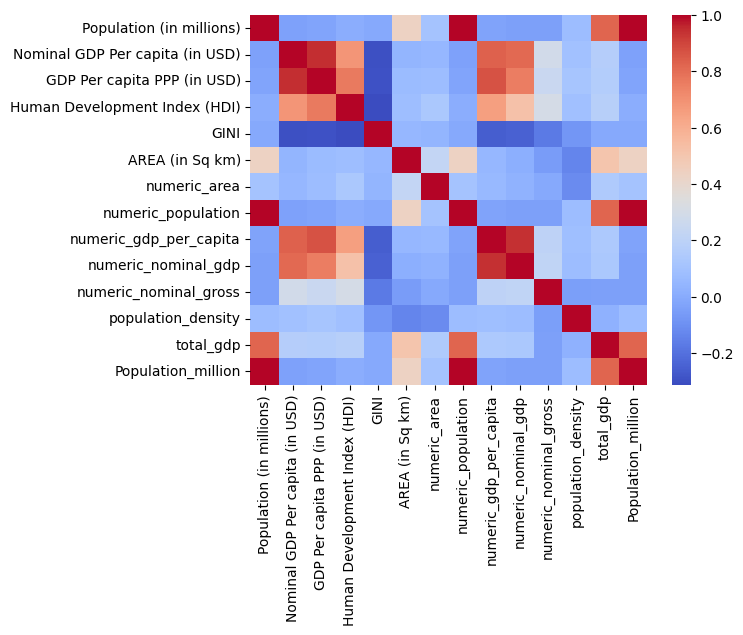

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = newData.corr(numeric_only= True)
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")


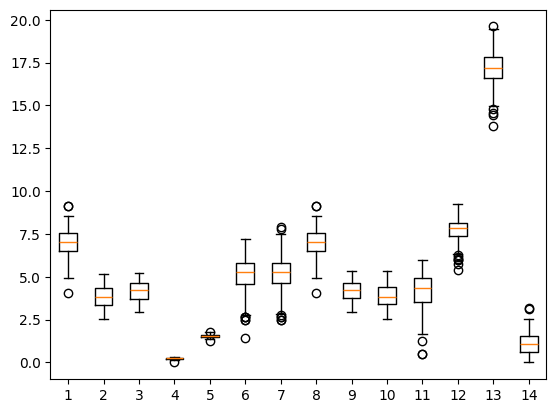

In [ ]:
import numpy as np
plt.boxplot(np.log10(newData.select_dtypes(include=['number'])+1))
plt.show()

Index(['country_name', 'Population (in millions)',
       'Nominal Gross Domestic Product (in USD)',
       'Nominal GDP Per capita (in USD)', 'GDP Per capita PPP (in USD)',
       'Human Development Index (HDI)', 'GINI', 'AREA (in Sq km)',
       'numeric_area', 'numeric_population', 'numeric_gdp_per_capita',
       'numeric_nominal_gdp', 'numeric_nominal_gross', 'HDI_category',
       'population_density', 'total_gdp', 'Population_million'],
      dtype='object')


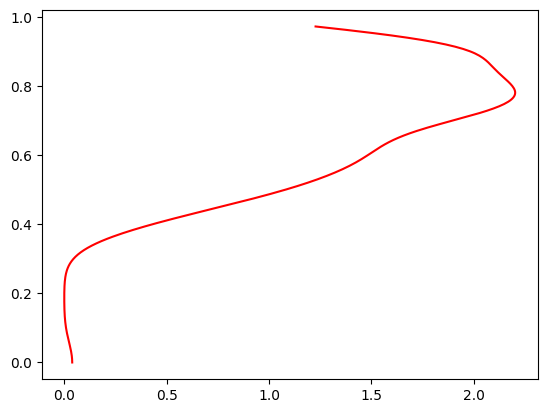

In [ ]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(newData['Human Development Index (HDI)'])
x_vals = np.linspace(min(newData['Human Development Index (HDI)']), max(newData['Human Development Index (HDI)']), 300)
plt.plot(kde(x_vals), x_vals, label='Smoothed (KDE)', color='red')
print(newData.columns)


{'whiskers': [<matplotlib.lines.Line2D at 0x7d69f8d65c90>,
 'caps': [<matplotlib.lines.Line2D at 0x7d69f8d670d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d69f8d653d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7d69f8d70450>,
 'fliers': [<matplotlib.lines.Line2D at 0x7d69f8d70d10>,
 'means': []}

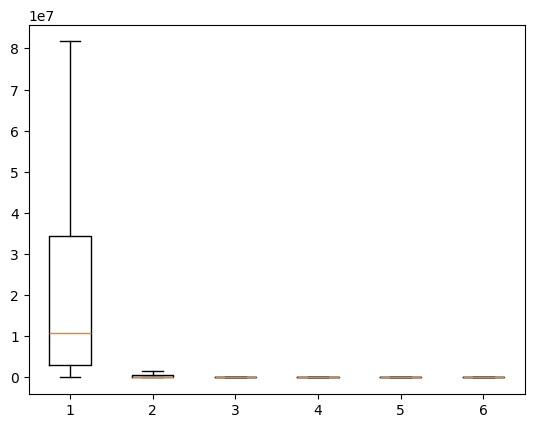

In [ ]:
def fit_outliers(x, q1, q3):
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    if x > upper:
        return upper
    elif x < lower:
        return lower
    else:
        return x

def iterate_for_outliers(numeric_dataset):
  df = numeric_dataset
  for col in df.columns:
    sf = df[col].quantile(0.75)
    tf = df[col].quantile(0.25)
    df[col] = df[col].apply(lambda x: fit_outliers(x,tf,sf))

feature_table = newData[['numeric_population','numeric_area','numeric_gdp_per_capita','numeric_nominal_gdp','numeric_nominal_gross','GINI']].copy()
target_table = newData[['Human Development Index (HDI)']].copy()
iterate_for_outliers(feature_table)
iterate_for_outliers(target_table)
plt.boxplot(feature_table)





In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=1.0)
ridge.fit(feature_table, target_table)
ridge_preds = ridge.predict(feature_table)
print("Ridge R²:", r2_score(target_table, ridge_preds))
lasso = Lasso(alpha=0.1)
lasso.fit(feature_table, target_table)
lasso_preds = lasso.predict(feature_table)
print("Lasso R²:", r2_score(target_table, lasso_preds))

linear_model = LinearRegression()
forest_model = RandomForestRegressor()
linear_model.fit(feature_table,target_table)
forest_model.fit(feature_table, target_table)

print(f" Ridge R²: {r2_score(target_table, ridge_preds)}\n Lasso R²:{r2_score(target_table, ridge_preds)}\n Linear R²: {linear_model.score(feature_table,target_table)}\n Random Forest R²: {forest_model.score(feature_table,target_table)}")


Ridge R²: 0.6505022811020928
Lasso R²: 0.6455000343281057
 Ridge R²: 0.6505022811020928
 Lasso R²:0.6505022811020928
 Linear R²: 0.6505022811668715
 Random Forest R²: 0.9759347669542823


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


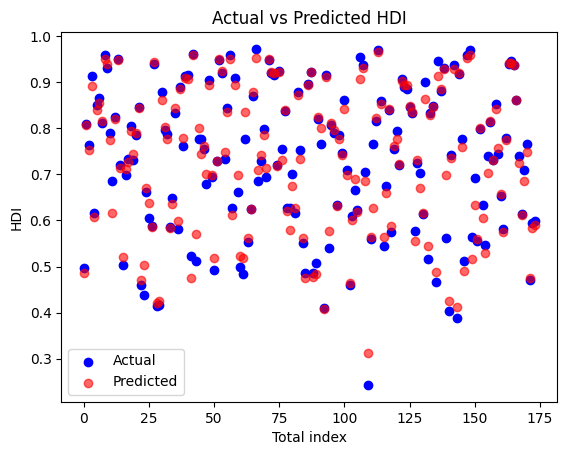

In [ ]:
plt.scatter(range(len(target_table)), target_table, color='blue', label='Actual')
plt.scatter(range(len(target_table)), forest_model.predict(feature_table), color='red', label='Predicted', alpha=0.6)
plt.xlabel('Total index')
plt.ylabel('HDI')
plt.title('Actual vs Predicted HDI')
plt.legend()
plt.show()

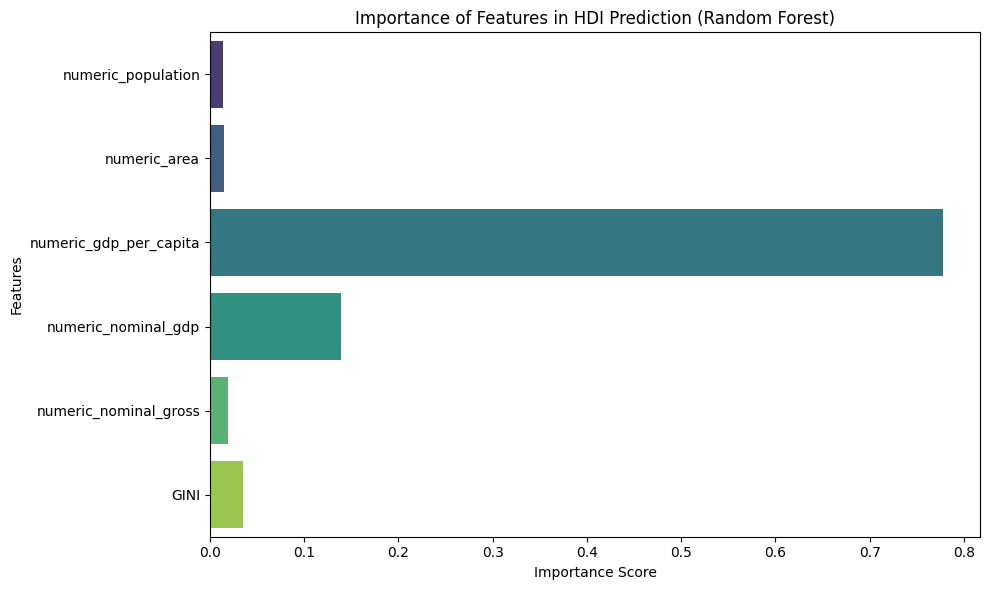

                  Feature  Importance
2  numeric_gdp_per_capita    0.778124
3     numeric_nominal_gdp    0.139340
5                    GINI    0.034850
4   numeric_nominal_gross    0.019662
1            numeric_area    0.014512
0      numeric_population    0.013511


In [ ]:
importances = forest_model.feature_importances_
feature_names = feature_table.columns

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, hue=feature_names, palette='viridis', legend=False)
plt.title("Importance of Features in HDI Prediction (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Detailed textual analysis
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

models_fitted = {
    "Linear Regression": linear_model,
    "Ridge Regression": ridge,
    "Lasso Regression": lasso,
    "Random Forest": forest_model
}

for name, model in models_fitted.items():
    preds = model.predict(feature_table)
    mse = mean_squared_error(target_table, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(target_table, preds)
    print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")


Linear Regression - RMSE: 0.0935, MAE: 0.0719
Ridge Regression - RMSE: 0.0935, MAE: 0.0719
Lasso Regression - RMSE: 0.0942, MAE: 0.0728
Random Forest - RMSE: 0.0245, MAE: 0.0152


In [ ]:
from sklearn.model_selection import cross_val_score

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor()
}

for name, model in models.items():
    scores = cross_val_score(model, feature_table, target_table.values.ravel(), cv=5, scoring='r2')
    print(f"{name} - CV R²: {scores.mean():.4f} ± {scores.std():.4f}")


Linear Regression - CV R²: 0.6173 ± 0.1462
Ridge Regression - CV R²: 0.6173 ± 0.1462
Lasso Regression - CV R²: 0.6114 ± 0.1493
Random Forest - CV R²: 0.8566 ± 0.0875


In [ ]:
import plotly.express as px

# Create an interactive world map showing HDI by country
fig = px.choropleth(
    newData,
    locations='country_name',               # Column with country names
    locationmode='country names',           # Use country names for matching
    color='Human Development Index (HDI)',  # Column to color by (HDI)
    hover_name='country_name',              # Show country name on hover
    color_continuous_scale='Viridis',       # Color scale
    title='World Countries - Human Development Index (HDI)'  # Map title
)

fig.show()

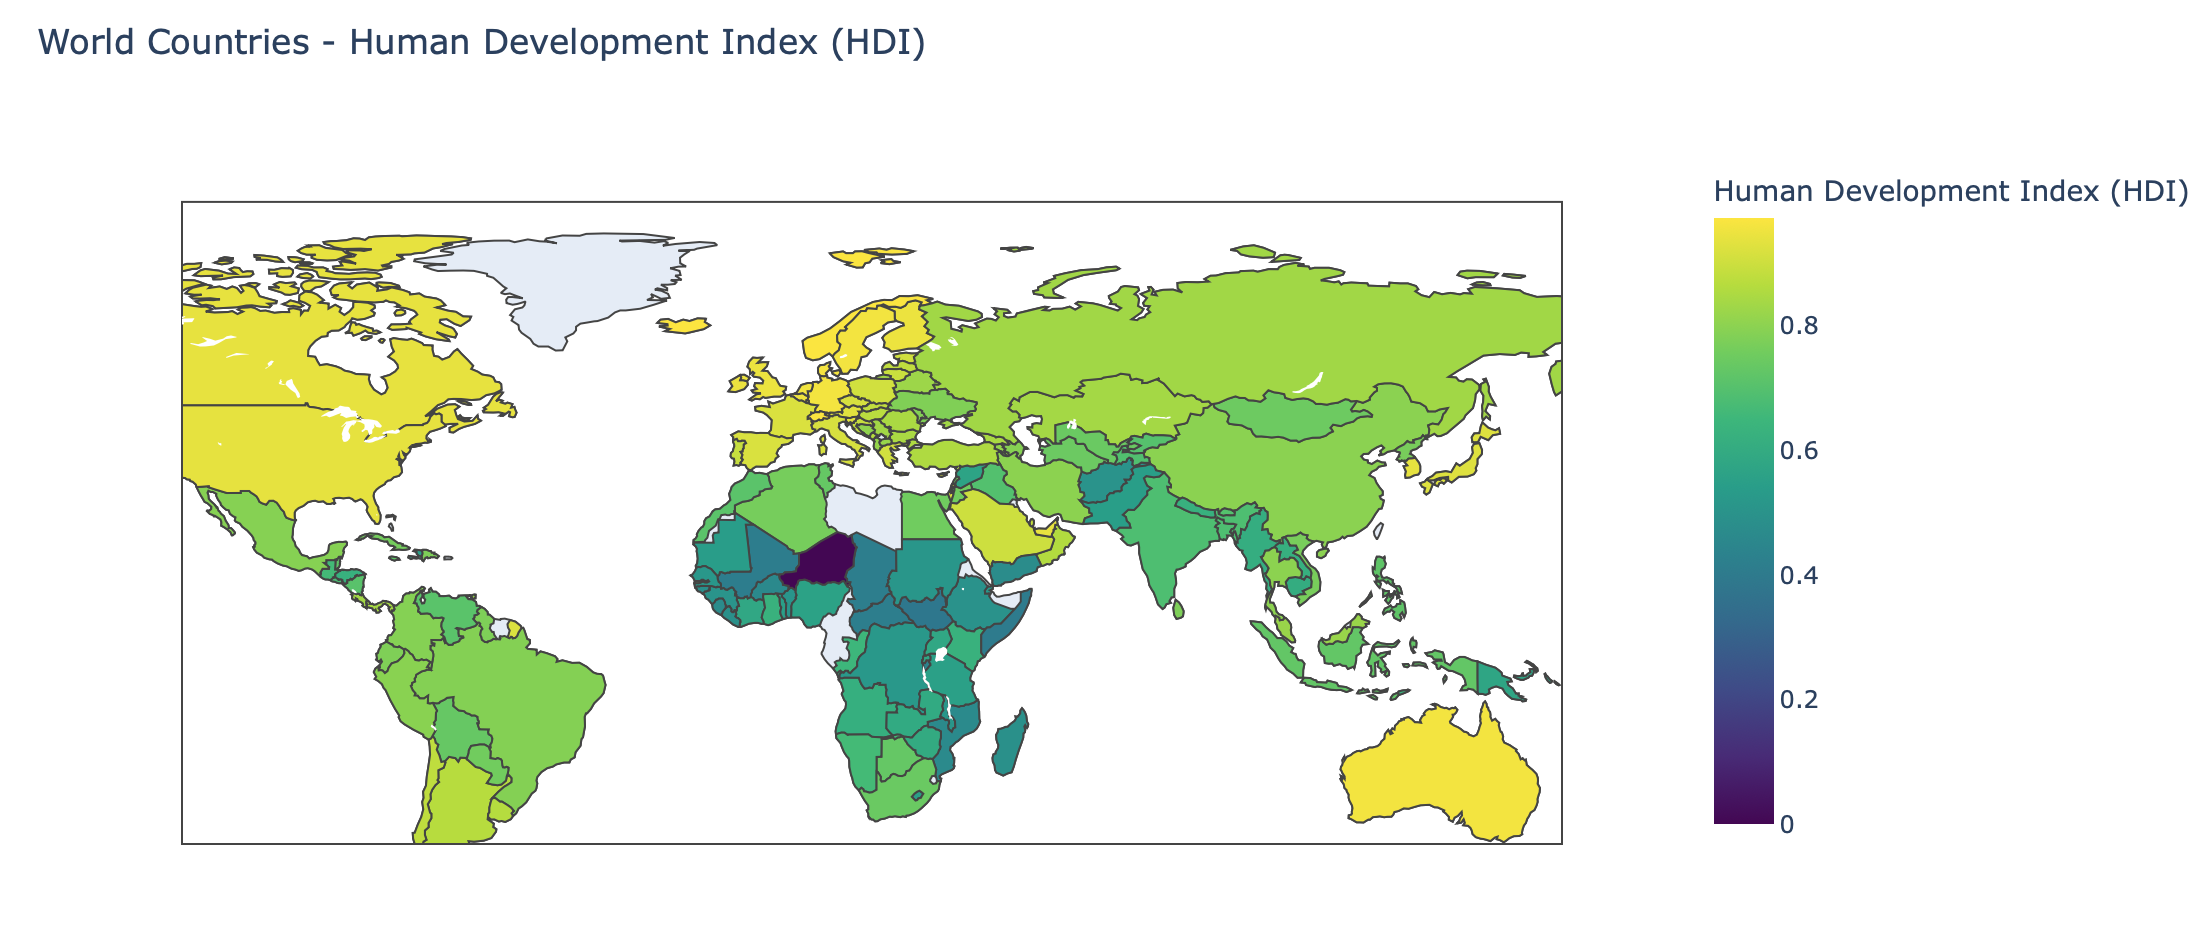

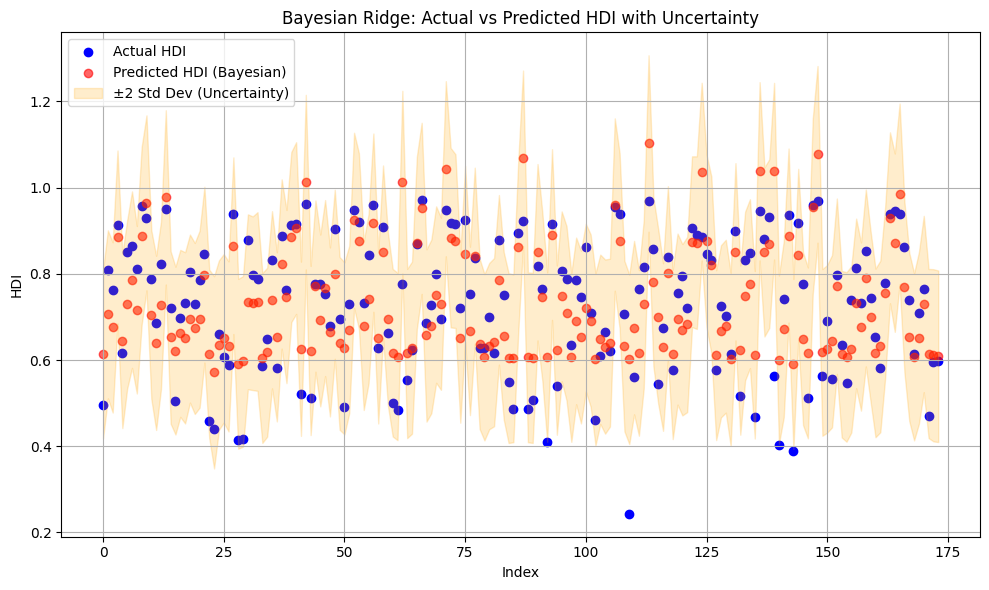

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(target_table))

plt.figure(figsize=(10,6))


plt.scatter(x, target_table.values.ravel(), color='blue', label='Actual HDI')


plt.scatter(x, bayesian_preds, color='red', alpha=0.6, label='Predicted HDI (Bayesian)')


plt.fill_between(
    x,
    bayesian_preds - 2*stds,
    bayesian_preds + 2*stds,
    color='orange',
    alpha=0.2,
    label='±2 Std Dev (Uncertainty)'
)

plt.xlabel('Index')
plt.ylabel('HDI')
plt.title('Bayesian Ridge: Actual vs Predicted HDI with Uncertainty')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
